<a href="https://colab.research.google.com/github/dmika1234/ml_uwr_22/blob/develop/Assignments/Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 8

**Submission deadline:**
* **lab session in the week 12-16.12.22**

**Points: 2+2+2=6 points**


In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
# !pip install -q gdown httpimport

In [2]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# More of Gradient Descent

## Linear regression example

In [3]:
# Repeat notebook initialization and data loading

import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

iris = sklearn.datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = pd.Categorical(iris.target_names[iris.target])

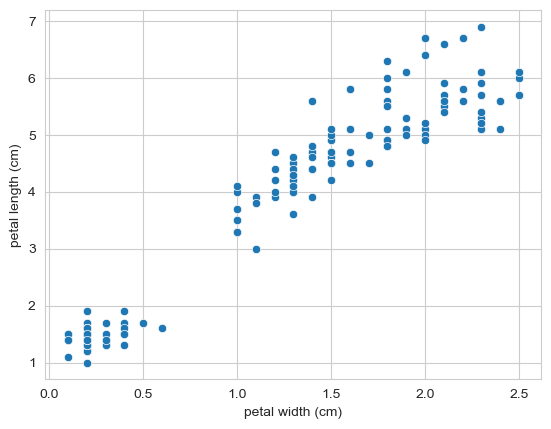

In [4]:
reg_feature='petal width (cm)'
reg_target='petal length (cm)'

# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

In [5]:
X = iris_df[[reg_feature]]
y = np.asarray(iris_df[reg_target]).reshape(-1,1)

In [6]:

class LinearRegression:
        
    def __init__(self):
        pass
    
    def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    def grad(self, Theta, X, y):
        n = X.shape[0]
        E = X @ Theta - y
        return (2./n) * X.T @ E

    
    def fit(self, X, y):
        X = self.add_ones(X)
        y = np.asarray(y).reshape(-1,1)
        
        Theta = np.zeros((X.shape[1], 1)) #sane starting Theta

        alpha=1e-3
        grad_norm = 1.
        while (grad_norm > 1e-4):
            grad_Theta = self.grad(Theta,X,y)
            Theta = Theta - alpha*grad_Theta
            
            grad_norm = np.linalg.norm(grad_Theta)

        self.ThetaOpt = Theta
    
    def predict(self, X):
        return self.add_ones(X) @ self.ThetaOpt

In [7]:
model = LinearRegression()
model.fit(X,y)
print(model.ThetaOpt)

[[1.08376085]
 [2.22980612]]


In [8]:
y_pred = model.predict(X)

In [9]:
def mse(y_true, y_pred):
    return ((y_pred - y_true)**2).mean()

In [10]:
mse(y, y_pred)

0.22563169993495052

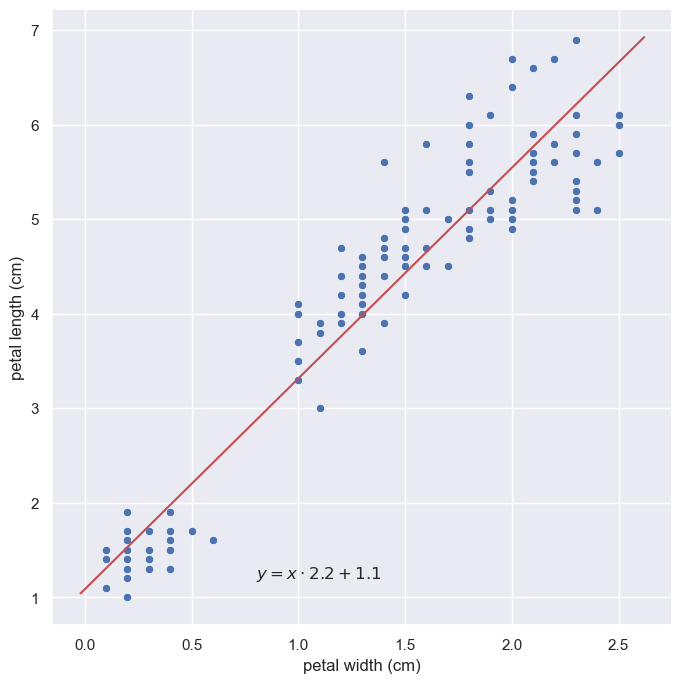

In [11]:
# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = model.ThetaOpt[1] * length_bounds + model.ThetaOpt[0]

plt.plot(length_bounds, width_predictions, color='r')
_ = plt.text(0.8, 1.2, f"$y = x \cdot {float(model.ThetaOpt[1]):0.2} + {float(model.ThetaOpt[0]):0.2}$")

## Stochastic gradient descent

The cost function for linear regression (assume $X$ is a vector of shape `(n,1)`) is $J_{X,y}(\Theta) = \frac{1}{n}\sum_{i=1}^n \left( y^{i} - \Theta_0 - \Theta_1 \cdot x^{i}\right)^2$. The gradient of the linear regression is equal to $\frac{2}{n} X^T \cdot (X \cdot \Theta - y)$. Let's break it down:

$$
\begin{align}
\frac{\partial J_{X,y}(\Theta)}{\partial \Theta_0} &= - \sum_{i=1}^n \frac{2}{n}\left( y^i - \Theta_0 - \Theta_1 \cdot x^i\right) \\
\frac{\partial J_{X,y}(\Theta)}{\partial \Theta_1} &= - \sum_{i=1}^n \frac{2}{n}\left( y^i - \Theta_0 - \Theta_1 \cdot x^i\right) \cdot x^i
\end{align}
$$

Notice one thing: if we will pick one training sample $x^{\text{rand}}$ at random and calculate $- 2\left( y^{\text{rand}} - \Theta_0 - \Theta_1 \cdot x^{\text{rand}}\right) \cdot x^{\text{rand}}$, then it's expected value will be equal to 
$$
\begin{align}
\mathbb{E}\left[ - 2\left( y^{\mbox{rand}} - \Theta_0 - \Theta_1 \cdot x^{\mbox{rand}}\right) \cdot x^{\mbox{rand}} \right] = - \sum_{i=1}^n \frac{2}{n}\left( y^i - \Theta_0 - \Theta_1 \cdot x^i\right) \cdot x^i.
\end{align}
$$

Point being that one sample already may give a reasonable estimation of the gradient calculated on the whole set.

At the same time $- 2\left( y^{\text{rand}} - \Theta_0 - \Theta_1 \cdot x^{\text{rand}}\right) \cdot x^{\text{rand}}$ just happens to be the gradient over $\Theta_1$ for the loss function calculated not on the entire $X$ (which is $\frac{\partial J_{X,y}(\Theta)}{\partial \Theta_1}$, but on $[x^{\text{rand}}]$ being $$\frac{\partial J_{x^{\text{rand}},y^{\text{rand}}}(\Theta)}{\partial \Theta_1}$$.

Point being that the calculations of the gradient do not have to look at the entire set. Let's look at the linear regression example one more time. **Remark** the below is the extreme case when we calculate the gradient only on one sample. In practice it may be better to 

In [12]:

class StochasticGradientDescentLinearRegression:
        
    def __init__(self):
        pass
    
    def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    def grad(self, Theta, X, y):
        #############################################
        ############  LOOK HERE  ####################
        #############################################

        rand = np.random.randint(X.shape[0])
        x_rand = X[rand].reshape(1,X.shape[1])
        y_rand = y[rand]
        
        E = x_rand @ Theta - y_rand
        return (2.) * x_rand.T @ E
    
    def fit(self, X, y):
        X = self.add_ones(X)
        y = np.asarray(y).reshape(-1,1)
        
        Theta = np.zeros((X.shape[1], 1)) #sane starting Theta

        alpha=1e-3
        grad_norm = 1.
        while (grad_norm > 1e-4):
            grad_Theta = self.grad(Theta,X,y)
            Theta = Theta - alpha*grad_Theta
            
            grad_norm = np.linalg.norm(grad_Theta)
            
        self.ThetaOpt = Theta
    
    def predict(self, X):
        return self.add_ones(X) @ self.ThetaOpt

In [13]:
model = StochasticGradientDescentLinearRegression()
model.fit(X,y)
print(model.ThetaOpt)

[[1.09237278]
 [2.22646455]]


In [14]:
y_pred = model.predict(X)
mse(y, y_pred)

0.22566024547680105

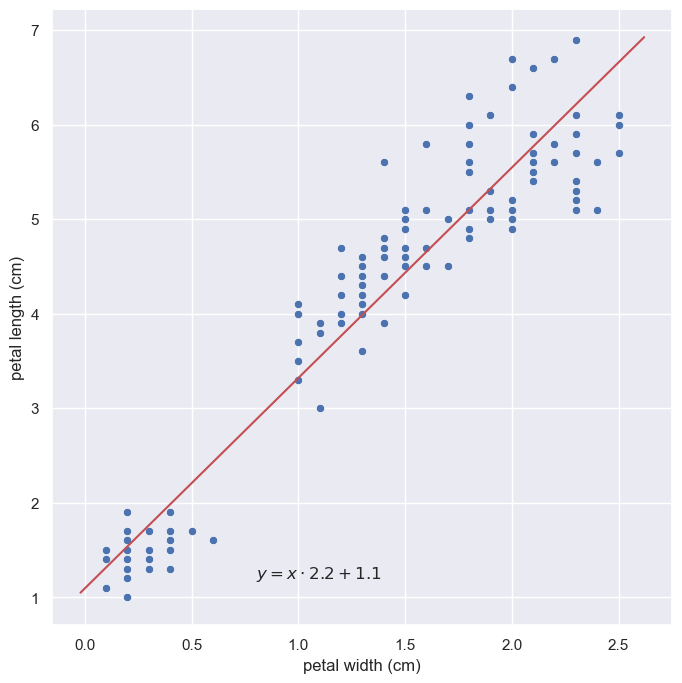

In [15]:
# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = model.ThetaOpt[1] * length_bounds + model.ThetaOpt[0]

plt.plot(length_bounds, width_predictions, color='r')
_ = plt.text(0.8, 1.2, f"$y = x \cdot {float(model.ThetaOpt[1]):0.2} + {float(model.ThetaOpt[0]):0.2}$")

## Using an automated optimizer

Writing by hand the optimization loops of gradient descent can be quite problematic sometimes (and sometimes boring). That's why sometimes we can use an automated optimizer which requires us just to give the methods for calculating the loss and a gradient. Let's have a look:

In [16]:
import scipy.optimize as sopt
class BFGSLinearRegression:
        
    def __init__(self):
        pass
    
    def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    def grad(self, Theta, X, y):
        Theta = Theta.reshape(-1,1) #### that's something new, cause bfgs uses different shape

        n = X.shape[0]
        E = X @ Theta - y
        return (2./n) * X.T @ E
    
    def loss(self, Theta, X, y):
        Theta = Theta.reshape(-1,1) #### that's something new, cause bfgs uses different shape
        
        n = X.shape[0]
        E = X @ Theta - y
        return (1./n) * E.T @ E
        
    def mse_loss_grad(self, Theta, X, y):
        return self.loss(Theta, X, y), self.grad(Theta, X, y)
    
    def fit(self, X, y):
        X = self.add_ones(X)
        y = np.asarray(y).reshape(-1,1)
        
        Theta0 = np.zeros((X.shape[1], 1)) 

        self.ThetaOpt = sopt.fmin_l_bfgs_b( ### and that's something new
            lambda Theta: self.mse_loss_grad(Theta, X, y), np.array(Theta0))[0]
    
    def predict(self, X):
        return self.add_ones(X) @ self.ThetaOpt

In [17]:

model = BFGSLinearRegression()
model.fit(X,y)
print(model.ThetaOpt)

[1.0835583  2.22994077]


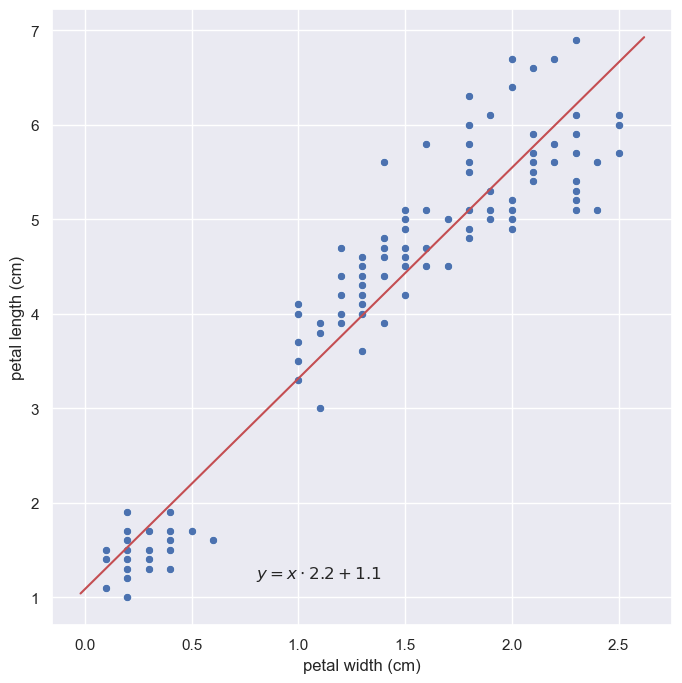

In [18]:
# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = model.ThetaOpt[1] * length_bounds + model.ThetaOpt[0]

plt.plot(length_bounds, width_predictions, color='r')
_ = plt.text(0.8, 1.2, f"$y = x \cdot {float(model.ThetaOpt[1]):0.2} + {float(model.ThetaOpt[0]):0.2}$")

## Automatic gradient

Writing your own gradient optimization is already quite problematic. Writing your own gradient calculations is even more problematic once your models are even slightly more complicated than linear or logistic regression. That's why it's incredibly convenient to use automatic differentiation. PyTorch, Keras and Tensorflow are the most popular tools for this (although they offer way more than what we are about to see).
When writing simple things like we do, PyTorch is the simplest. So let's check it out.

In [19]:
# !pip install torch

In [20]:
import torch 

X_tensor = torch.tensor(np.asarray(X))
y_tensor = torch.tensor(y)

In [21]:
X_tensor

tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.3000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.1000],
        [0.2000],
        [0.4000],
        [0.4000],
        [0.3000],
        [0.3000],
        [0.3000],
        [0.2000],
        [0.4000],
        [0.2000],
        [0.5000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.3000],
        [0.3000],
        [0.2000],
        [0.6000],
        [0.4000],
        [0.3000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [1.4000],
        [1.5000],
        [1.5000],
        [1.3000],
        [1.5000],
        [1

In [22]:
y_tensor

tensor([[1.4000],
        [1.4000],
        [1.3000],
        [1.5000],
        [1.4000],
        [1.7000],
        [1.4000],
        [1.5000],
        [1.4000],
        [1.5000],
        [1.5000],
        [1.6000],
        [1.4000],
        [1.1000],
        [1.2000],
        [1.5000],
        [1.3000],
        [1.4000],
        [1.7000],
        [1.5000],
        [1.7000],
        [1.5000],
        [1.0000],
        [1.7000],
        [1.9000],
        [1.6000],
        [1.6000],
        [1.5000],
        [1.4000],
        [1.6000],
        [1.6000],
        [1.5000],
        [1.5000],
        [1.4000],
        [1.5000],
        [1.2000],
        [1.3000],
        [1.4000],
        [1.3000],
        [1.5000],
        [1.3000],
        [1.3000],
        [1.3000],
        [1.6000],
        [1.9000],
        [1.4000],
        [1.6000],
        [1.4000],
        [1.5000],
        [1.4000],
        [4.7000],
        [4.5000],
        [4.9000],
        [4.0000],
        [4.6000],
        [4

In [23]:
X_tensor.shape, y_tensor.shape

(torch.Size([150, 1]), torch.Size([150, 1]))

In [24]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(a)
print(b)

tensor([-0.9135], requires_grad=True)
tensor([-0.6742], requires_grad=True)


The following cell calculates the gradient of Mean Square error loss in a given Theta:

In [25]:
loss = (( X_tensor * a + b - y_tensor)**2).mean() #calculate the loss
loss.backward() #calculate the gradient of all variables that require_grad
with torch.no_grad(): #freeze the computational graph of derivatives
    print(a.grad, b.grad) #print out the gradient

tensor([-16.8876]) tensor([-11.0556])


And that's it. Now we just have to do it in a loop to do the gradient descent.

In [26]:
#usually this function is called `forward` in pytorch although in our context it was always called `predict`
def model(X): 
    return X * a + b

In [27]:
def mse( y_pred, y_true):
    return torch.mean( (y_pred - y_true)**2)

loss_func = mse

In [28]:
alpha = 0.05

for i in range(1000):
    #loss =  (( X_tensor * a + b - y_tensor)**2).mean() 
    loss = loss_func(model(X_tensor), y_tensor) # calculate the loss in a given Theta
    loss.backward() #calculate the gradients in a given Theta
    with torch.no_grad(): #turn off gradient calculations to update the gradients
        a -= a.grad * alpha
        b -= b.grad * alpha
        a.grad.zero_() #zero the gradients once used
        b.grad.zero_()


In [29]:
Theta = np.asarray( [b.detach().numpy(), a.detach().numpy()]) 
#a and b are still active variables in the computational graph of derivatives
#that's why we need to .detach() before accesing their values

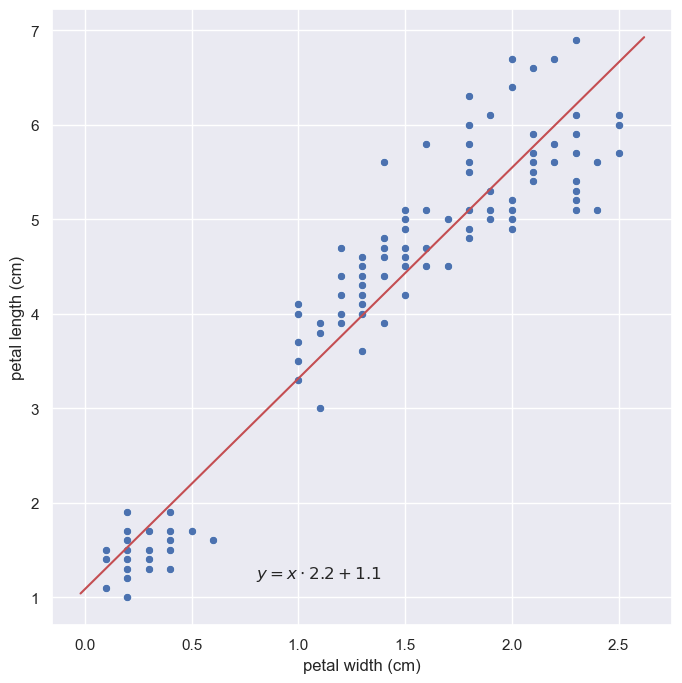

In [30]:
# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

# plot the proposed relationship
length_bounds = np.array(plt.xlim())
width_predictions = Theta[1] * length_bounds + Theta[0]

plt.plot(length_bounds, width_predictions, color='r')
_ = plt.text(0.8, 1.2, f"$y = x \cdot {float(Theta[1]):0.2} + {float(Theta[0]):0.2}$")

# MNIST

In [31]:
with np.load('mnist.npz') as data:
    mnist_train_data = data[
        'train_data'].astype(np.float32).reshape(-1, 28*28) / 255.0
    mnist_train_labels = data['train_labels']
    mnist_test_data = data[
        'test_data'].astype(np.float32).reshape(-1, 28*28) / 255.0
    mnist_test_labels = data['test_labels']

(X_train, y_train), (X_test, y_test) = (mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels)

In [83]:
def one_hot(y, c):

    # y--> label/ground truth.
    # c--> Number of classes.

    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))

    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[np.arange(len(y)), y] = 1

    return y_hot

def softmax(Theta, X):
    z = X @ Theta
    exp = np.exp(z - np.max(z))
    return exp / np.sum(exp, axis=1)[:, None]

def calc_loss(y_hat, y_labels):
    loss = -np.mean(np.log(y_hat[np.arange(len(y_labels)), y_labels]))
    return loss

def add_ones(X):
    return np.hstack((np.ones((X.shape[0], 1)), X))


def grad(X, y_hat, y_hot):
    m, n = X.shape
    grad = (1/m) * np.dot(X.T, (y_hat - y_hot))
    return grad

def accuracy(y, y_hat):
    return np.sum(y==y_hat)/len(y)

Remember to use `SoftMax` in all of the below exercises.

## Problem 1 [2p]

Implement the stochastic gradient descent for MNIST as in `StochasticGradientDescentLinearRegression`. **Remark** it may be better for training to sample not one $x^{\mbox{rand}}$ but a small subset of the $X$ data to get better estimations of the gradient.

In [192]:
class StochasticGradientDescentSoftmaxRegression:

    def __init__(self, c):
        self.ThetaOpt = None
        self.c = c

    def fit(self, X, y, lr=0.9, mini_batches=100, epochs=1000, eta=1e-4, verbose=False):
        X = add_ones(X)
        m, n = X.shape
        # y = np.asarray(y).reshape(-1,1)
        # One-hot encoding y.
        y_hot = one_hot(y, self.c)
        Theta = np.random.random((n, self.c)) #sane starting Theta
        losses = []
        # Training loop.
        for epoch in tqdm(np.arange(epochs)):
            # Calculating hypothesis/prediction.
            y_hat = softmax(Theta, X)

            # Taking batches
            idx = np.random.choice(np.arange(m), mini_batches)
            X_batch = X[idx]
            y_hat_batch = y_hat[idx]
            y_hot_batch = y_hot[idx]

            # Calculating the gradient of loss w.r.t w and b.
            grad_Theta = grad(X_batch, y_hat_batch, y_hot_batch)
            Theta = Theta - lr * grad_Theta
            grad_norm = np.linalg.norm(grad_Theta)

            # Calculating loss and appending it in the list.
            loss = -np.mean(np.log(y_hat[np.arange(len(y)), y]))
            losses.append(loss)

            # Printing out the loss at every 100th iteration.
            if verbose and epoch % 100 == 0:
                print(f'Epoch {epoch}==> Loss = {loss}')

            if grad_norm <= eta:
                break
        self.ThetaOpt = Theta
        return Theta, losses

    def predict(self, X):
        X = add_ones(X)
        z = X @ self.ThetaOpt
        y_hat = softmax(z)
        return np.argmax(y_hat, axis=1)

In [58]:
sgdsoft_clf = StochasticGradientDescentSoftmaxRegression(10)
sgdsoft_clf.fit(X_train, y_train)

100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]


(array([[-3.78983682e-02,  8.14528961e-01,  5.47175241e-01, ...,
          1.17557426e+00, -1.59157418e+00,  5.50884235e-06],
        [ 4.78608899e-01,  7.43056705e-01,  7.00530370e-01, ...,
          1.48738655e-01,  5.85909682e-01,  1.57610060e-01],
        [ 7.29117077e-01,  6.35352244e-01,  1.86696083e-01, ...,
          6.89734624e-02,  2.62201056e-01,  6.02810970e-01],
        ...,
        [ 7.26169944e-02,  3.84862397e-01,  3.83050154e-01, ...,
          9.83088339e-01,  3.28529783e-01,  5.30157285e-01],
        [ 6.68729907e-01,  6.61736261e-01,  2.98530974e-01, ...,
          1.45541617e-01,  5.23690523e-01,  4.44055734e-01],
        [ 3.63134745e-02,  3.34058937e-01,  8.83760169e-01, ...,
          7.86712605e-01,  2.04784720e-01,  3.88245310e-01]]),
 [4.579690781492993,
  4.2101823730093795,
  3.3190973701856468,
  3.3224362992639183,
  3.051477502935849,
  2.726883321924926,
  2.4230544422522975,
  2.130890620361208,
  1.7904019902096568,
  1.1843655775689839,
  1.229717373

In [59]:
pred_bfgsoft = sgdsoft_clf.predict(X_test)
acc_sgdsoft = accuracy(pred_bfgsoft, y_test)
print(f'Accuracy obtained with StochasticGradientDescentSoftmaxRegression on mnist test data is {100*acc_sgdsoft:0.2f}%')

Accuracy obtained with StochasticGradientDescentSoftmaxRegression on mnist test data is 91.51%


## Problem 2 [2p]

Implement the stochastic gradient descent for MNIST as in `BFGSLinearRegression`. Also here calculate the gradient using a subset of the data, and not the whole $X$. Answer the question of how small the size of the subset can roughly be in order to give convergence of the training. Don't give incredibly precise answer, just an order of magnitude is enough: is it 10, 50, 100, 500, 1000?

In [175]:
import scipy.optimize as sopt
class BFGSSoftmaxRegression:

    def __init__(self, c):
        self.ThetaOpt = None
        self.c = c

    def softmax(self, Theta, X):
        z = X @ Theta.reshape(-1, self.c)
        exp = np.exp(z - np.max(z))
        return exp / np.sum(exp, axis=1)[:, None]

    def loss(self, y_hat, y_labels):
        loss = -np.mean(np.log(y_hat[np.arange(len(y_labels)), y_labels]))
        return loss


    def grad(self, X, y_hat, y_hot):
        m, n = X.shape
        grad = (1/m) * np.dot(X.T, (y_hat - y_hot))
        return grad


    def mse_loss_grad(self, Theta, X, y_hot, y_labels):
        y_hat = self.softmax(Theta, X)
        return self.loss(y_hat, y_labels), self.grad(X, y_hat, y_hot).reshape(-1, 1)

    def fit(self, X, y, maxiter=1000):
        X = add_ones(X)
        m, n = X.shape
        y_hot = one_hot(y, self.c)
        Theta0 = np.random.random((n * self.c, 1))

        ThetaOpt = sopt.fmin_l_bfgs_b(lambda Theta: self.mse_loss_grad(Theta, X, y_hot, y),
                                           np.array(Theta0), maxiter=maxiter)[0]
        self.ThetaOpt = ThetaOpt.reshape(-1, self.c)

    def predict(self, X):
        X = add_ones(X)
        y_hat = self.softmax(Theta, X)
        return np.argmax(y_hat, axis=1)

In [55]:
bfgsoft_clf = BFGSSoftmaxRegression(10)
bfgsoft_clf.fit(X_train, y_train)

In [56]:
pred_bfgsoft = bfgsoft_clf.predict(X_test)
acc_bfgsoft= accuracy(pred_bfgsoft, y_test)
print(f'Accuracy obtained with BFGSSoftmaxRegression on mnist test data is {100*acc_bfgsoft:0.2f}%')

Accuracy obtained with BFGSSoftmaxRegression on mnist test data is 92.22%


## Problem 3 [2p]

Implement the stochastic gradient descent for MNIST using PyTorch.

In [232]:
import torch
# from d2l import torch as d2l

class PyTorchSoftmaxRegression:

    def __init__(self, c):
        self.ThetaOpt = None
        self.c = c

    def softmax(self, Theta, X):
        z = torch.mm(X, Theta)
        exp = torch.exp(z - torch.max(z))
        return exp / torch.sum(exp, axis=1)[:, None]

    def loss(self, y_hat, y):
        loss = -torch.mean(torch.log(y_hat[np.arange(len(y)), y]))
        return loss


    def fit(self, X, y, lr=0.9, mini_batches=100, epochs=100, eta=1e-4, verbose=False):
        X = add_ones(X)
        X = torch.tensor(X).double()
        y = torch.tensor(y)
        m, n = X.shape
        # y_hot = one_hot(y, self.c)
        Theta = torch.nn.Parameter(torch.randn((n, self.c), requires_grad=True).double())
        losses = []
        # Training loop.
        for epoch in tqdm(np.arange(epochs)):
            # Taking batches
            idx = np.random.choice(np.arange(m), mini_batches)
            X_batch = X[idx]
            y_batch = y[idx]
            # y_hat_batch = y_hat[idx]
            # y_hot_batch = y_hot[idx]

            # Calculating the gradient of loss w.r.t w and b.
            loss = self.loss(self.softmax(Theta, X_batch), y_batch)  # calculate the loss in a given Theta
            losses.append(loss)
            loss.backward()  #calculate the gradients in a given Theta
            with torch.no_grad():  #turn off gradient calculations to update the gradients
                Theta -= Theta.grad * lr
                Theta.grad.zero_()  #zero the gradients once used

            # Printing out the loss at every 100th iteration.
            if verbose and epoch % 100 == 0:
                print(f'Epoch {epoch}==> Loss = {loss}')

        self.ThetaOpt = Theta.detach()
        # return np.asarray(Theta.detach().numpy()), losses

    def predict(self, X):
        X = add_ones(X)
        X = torch.tensor(X).double()
        y_hat = self.softmax(self.ThetaOpt, X).detach().numpy()
        return np.argmax(y_hat, axis=1)

In [237]:
torchsoft_clf = PyTorchSoftmaxRegression(10)
torchsoft_clf.fit(X_train, y_train, epochs=10000)

100%|██████████| 10000/10000 [00:28<00:00, 356.20it/s]


In [238]:
pred_torchsoft = torchsoft_clf.predict(X_test)
acc_torchsoft= accuracy(pred_torchsoft, y_test)
print(f'Accuracy obtained with PyTorchSoftmaxRegression on mnist test data is {100*acc_torchsoft:0.2f}%')

Accuracy obtained with PyTorchSoftmaxRegression on mnist test data is 91.13%
